**Custom Models and Training with TensorFlow**


This notebook is inspired from the handson-ml2 GitHub repository by Aurélien Geron

https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [20]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -U tqdm
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Tensors and operations

### Tensors

In [ ]:
# Scalar Tensor of integer

tf.constant(42)

In [ ]:
# Scalar Tensor of Float


tf.constant(42.1)

In [ ]:
# Tensor representing matrix with two rows and three columns of floats

tf.constant([[1., 2., 3.], [4., 5., 6.]])

In [ ]:
# Check shape of Tensor

t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

In [ ]:
# Check data type of Tensor

t.dtype

In [ ]:
# Tensor Operation - Addition

t + 5

In [ ]:
# Tensor Operation - Addition - Another way


tf.add(t,5)

In [ ]:
# Tensor Operation - Square

tf.square(t)

In [ ]:
# Tensor Operation - Multiply

tf.multiply(t, 5)

In [ ]:
# Tensor Operation - Square root

tf.sqrt(t)

In [ ]:
# Tensor Operation - Transpose

tf.transpose(t)

In [ ]:
# Tensor Operation - Matrix Multiplication

tf.matmul(t, tf.transpose(t))

In [ ]:
# # Tensor Operation - Matrix Multiplication - Another way

t @ tf.transpose(t)

### From/To NumPy

In [ ]:
# Creating tensor from NumPy array

a = np.array([2., 4., 5.])
tf.constant(a)

In [ ]:
# Convert tensor to Numpy array

t.numpy()

In [ ]:
# Convert tensor to Numpy array - Another way

np.array(t)

In [ ]:
# Creating tensor from NumPy array

tf.square(a)

In [ ]:
# Convert tensor to Numpy array

np.square(t)

### Conflicting Types

In [ ]:
# Adding tensors of float and integer

# tf.constant(2.0) + tf.constant(40)

# The above code will throw exception

In [ ]:
# Adding tensors of float and integer
# Handling Exception

try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

In [ ]:
# Adding tensors of 32-bit and 64-bit
# Handling Exception

try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

In [ ]:
# Type Casting
# Converting 64-bit tensor to 32-bit and then adding tensors

t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

### Variables

In [ ]:
# tf variable with two rows and three columns

v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

In [ ]:
# Modify in place with assign()

v.assign(2 * v)

In [ ]:
# Update cell with assign()
# Update cells with index (0,1) to 42.0

v[0, 1].assign(42.0)

In [ ]:
# Update cell with scatter_nd_update()
# Update cells with index (0,0) and (1,2) to 100.0 and 200.0 respectively

v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

### Other Data Structures - Strings

In [ ]:
# String Tensor - Byte String

tf.constant(b"hello world")

In [ ]:
# String Tensor - Unicode strings get encoded to utf-8 automatically

tf.constant("café")

In [ ]:
# Represent Unicode strings using tensor of type tf.int32

u = tf.constant([ord(c) for c in "café"])
u

### String arrays

In [ ]:
# Tensor of string arrays

p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])
p

### Ragged tensors

In [ ]:
# List of lists, with each being of variable length
# Consider a speech like this, where the length may change wildly on each line

speech = tf.ragged.constant(
  [['All', 'the', 'world', 'is', 'a', 'stage'],
  ['And', 'all', 'the', 'men', 'and', 'women', 'merely', 'players'],
  ['They', 'have', 'their', 'exits', 'and', 'their', 'entrances']])

speech

In [ ]:
print(speech[0])

In [ ]:
print(speech[1])

In [ ]:
# One more example of Ragged Tensors
# Variable-length features, such as the set of actors in a movie.

actors = tf.ragged.constant(
  [['Matt Damon', 'Robin Williams'],
  ['John Travolta', 'Samuel L. Jackson', 'Uma Thurman', 'Harvey Keitel', 'Bruce Willis'],
  ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton', 'William Sadler']])

actors

In [ ]:
print(actors[0])

In [ ]:
print(actors[1])

## Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [ ]:
# Use fetch_california_housing() function to load the data. 
# This dataset contains only numerical features (there is no ocean_proximity feature)
# And there is no missing value. 
# After loading the data, we split it into a training set, a validation set, and a test set
# And we scale all the features


from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# fetch the data
housing = fetch_california_housing()

# split it into a training set, a validation set, and a test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

# Scale all the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Custom Loss Function - Huber Loss

Let's implement huber loss. Huber loss is less sensitive to outliers in data than mean squared error.
Below is the formula of huber loss.

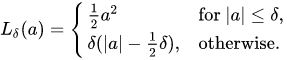

Huber loss (green) vs squared error loss (blue)

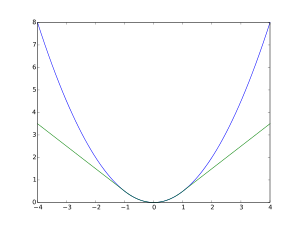

In [ ]:
# Define a custom loss function
# Define Huber loss function

def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
# Build the network.
# Output layer just contains 1 neuron since we have to predict only one value

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [ ]:
# Specify the loss function and the optimizer to use.
# Here we are using custom loss function
# Measure MAE during training and evaluation

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
# Train the model

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

## Saving/Loading Models with Custom Objects

In [ ]:
# Save the model

model.save("my_model_with_a_custom_loss.h5")

In [ ]:
# Load the model
# Specify the custom loss function while loading the model

loaded_model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})
loaded_model

## Other Custom Functions

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## Custom Metrics

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

**Warning**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

### Streaming metrics

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
precision.result()

In [ ]:
precision.variables

In [ ]:
precision.reset_states()

Creating a streaming metric:

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        #self.huber_fn = create_huber(threshold) # TODO: investigate why this fails
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def huber_fn(self, y_true, y_pred): # workaround
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**Warning**: when running the following cell, if you get autograph warnings such as `WARNING:tensorflow:AutoGraph could not transform [...] and will run it as-is`, then please install version 0.2.2 of the gast library (e.g., by running `!pip install gast==0.2.2`), then restart the kernel and run this notebook again from the beginning (see [autograph issue #1](https://github.com/tensorflow/autograph/issues/1) for more details):

In [ ]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

In [ ]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

In [ ]:
m.variables

In [ ]:
m.reset_states()
m.variables

Let's check that the `HuberMetric` class works well:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

In [ ]:
model.save("my_model_with_a_custom_metric.h5")

In [ ]:
#model = keras.models.load_model("my_model_with_a_custom_metric.h5",           # TODO: check PR #25956
#                                custom_objects={"huber_fn": create_huber(2.0),
#                                                "HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [ ]:
model.metrics[-1].threshold

Looks like it works fine! More simply, we could have created the class like this:

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

In [ ]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
#model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",        # TODO: check PR #25956
#                                custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [ ]:
model.metrics[-1].threshold

## Custom Layers

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
exponential_layer([-1., 0., 1.])

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.save("my_model_with_a_custom_layer.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

## Custom Models

In [ ]:
X_new_scaled = X_test_scaled

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

In [ ]:
model.save("my_custom_model.ckpt")

In [ ]:
model = keras.models.load_model("my_custom_model.ckpt")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5)

We could have defined the model using the sequential API instead:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

## Losses and Metrics Based on Model Internals

In [ ]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        # TODO: check https://github.com/tensorflow/tensorflow/issues/26260
        #self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        #if training:
        #    result = self.reconstruction_mean(recon_loss)
        #    self.add_metric(result)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

## TensorFlow Functions

#### Convert Python function to TensorFlow function

In [2]:
# Python function for calculating Square

def square(x):
    return x ** 2

In [3]:
# Returns square for integer

square(2)

4

In [4]:
# Convert Python Function to TensorFlow function

@tf.function
def square(x):
    return x ** 2

In [5]:
# Returns Tensor

square(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [6]:
# The Original Python function can be called with python_function attribute

square.python_function(2)

4

#### Autograph

In [8]:
# Get the code generated by TensorFlow

print(tf.autograph.to_code(square.python_function))

def tf__square(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('square', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
    do_return = True
    retval_ = fscope.mark_return_value(x ** 2)
  do_return,
  return ag__.retval(retval_)



#### Tracing

In [18]:
# TensorFlow computational graph is wrapped in concrete function get_concrete_function

concrete_function = square.get_concrete_function(tf.constant(2.0))
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
# showing tf.where

import tensorflow as tf
import numpy as np

condition = tf.Variable(
    np.array([[True, False, False],[False, True, False],[True, True, True]]), dtype = tf.bool, name = 'condition'
)

x = tf.Variable(
    np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]]), dtype = tf.float32, name = 'x'
)
y =tf.Variable(
    np.array([[11, 12, 13],[14, 15, 16],[17, 18, 19]]), dtype = tf.float32, name = 'y'
)

print(x)
print(y)
r = tf.where(condition, x, y)
print(r)

In [24]:
# Vectorized operation vs for loop


# With for loop
tic = time.process_time()
total = 0
for i in np.arange(100000):
    total = i + total
toc = time.process_time()

print("sum using for loop = "+ str(total)); 
print("Computation time = " + str(1000*(toc - tic )) + "ms")


# With numpy
tic = time.process_time()
total = np.sum(np.arange(100000))
toc = time.process_time()

print("sum using numpy = "+ str(total)); 
print("Computation time = " + str(1000*(toc - tic )) + "ms")

sum using for loop = 4999950000
Computation time = 77.94999999999952ms
sum using numpy = 4999950000
Computation time = 0.5579999999998364ms
